In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Khmer_Scan_Text_Recognition/

/content/drive/MyDrive/Khmer_Scan_Text_Recognition


In [3]:
#!pip install huggingface-hub ultralytics transformers Pillow opencv-python matplotlib torch

📥 Downloading YOLO model from Hugging Face...
🔍 Loading YOLOv8 model...
📚 Loading OCR model and processor...
🖼 Running YOLO inference on /content/rupp.jpg...

image 1/1 /content/rupp.jpg: 480x640 1 khmer_yolo_text, 218.2ms
Speed: 19.7ms preprocess, 218.2ms inference, 803.6ms postprocess per image at shape (1, 3, 480, 640)


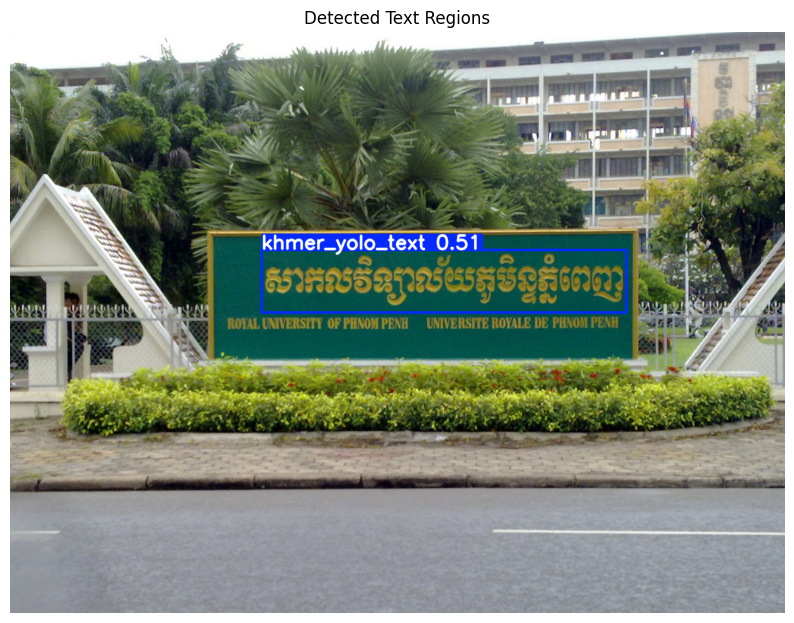

✂️ Processing cropped regions for OCR...
📝 Region 1: សាកលវិទ្យាល័យភូមិន្ទភ្នំពេញ


In [7]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt

# ====== Configuration ====== #
image_path = '/content/rupp.jpg'  # Your provided image path
repo_id = "lkhapple/Khmer-YOLOv8-Text-Detector"  # Hugging Face YOLO model repository
model_filename = "best.pt"  # YOLO model file

# ====== Download YOLO Model from Hugging Face ====== #
print("📥 Downloading YOLO model from Hugging Face...")
yolo_model_path = hf_hub_download(
    repo_id=repo_id,
    filename=model_filename,
)

# ====== Load Models ====== #
print("🔍 Loading YOLOv8 model...")
yolo_model = YOLO(yolo_model_path)
print("📚 Loading OCR model and processor...")
processor = TrOCRProcessor.from_pretrained("lkhapple/Khmer-STR-Model")
ocr_model = VisionEncoderDecoderModel.from_pretrained("lkhapple/Khmer-STR-Model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ocr_model.to(device)

# ====== YOLO Detection ====== #
print(f"🖼 Running YOLO inference on {image_path}...")
results = yolo_model(image_path)
annotated_image = results[0].plot()

# ====== Show Bounding Boxes ====== #
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Text Regions")
plt.axis('off')
plt.show()

# ====== OCR on Cropped Regions ====== #
print("✂️ Processing cropped regions for OCR...")
orig_img = cv2.imread(image_path)
if orig_img is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")
bboxes = results[0].boxes.xyxy.cpu().numpy()

if len(bboxes) == 0:
    print("⚠️ No text regions detected in the image.")
else:
    for i, box in enumerate(bboxes):
        x1, y1, x2, y2 = map(int, box)
        crop = orig_img[y1:y2, x1:x2]
        if crop.size == 0:  # Skip empty crops
            print(f"Warning: Empty crop for box {i+1}")
            continue

        # OCR
        pil_img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        inputs = processor(images=pil_img, return_tensors="pt").pixel_values.to(device)
        generated_ids = ocr_model.generate(inputs)
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        print(f"📝 Region {i+1}: {text}")